# result:

I will use all four. and use the same set of optimizer as in 1L models.

In [1]:
import h5py
import numpy as np
import os.path
from functools import partial
from collections import OrderedDict

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from scipy.stats import pearsonr

In [2]:
# get number of parameters.

In [3]:
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.cnn_exploration_pytorch import get_num_params

In [4]:
def generic_call_back(name, obj, env):
    if isinstance(obj, h5py.Dataset):
        arch, dataset, subset, neuron_idx, opt = name.split('/')
        assert dataset == 'MkA_Shape'
        neuron_idx = int(neuron_idx)
        corr_this = obj.attrs['corr']
        if corr_this.dtype != np.float32:
            # this will get hit by my code.
            assert corr_this == 0.0
        env['result'].append(
            {
                'subset': subset,
                'neuron': neuron_idx,
                'arch': arch,
                'opt': opt,
                'corr': corr_this,
                'time': obj.attrs['time'],
#                 'num_param': num_param_dict[arch],
            }
        )
        

def collect_all_data():
    cnn_explore_dir = os.path.join(dir_dictionary['models'], 'cnn_exploration_2L')
    env = {'result': []}
    count = 0
    for root, dirs, files in os.walk(cnn_explore_dir):
        for f in files:
            if f.lower().endswith('.hdf5'):
                count += 1
                if count % 100 == 0:
                    print(count)
                f_check = os.path.join(root, f)
                with h5py.File(f_check, 'r') as f_metric:
                    f_metric.visititems(partial(generic_call_back, env=env))
    
    result = pd.DataFrame(env['result'], columns=['subset', 'neuron', 'arch', 'opt', 'corr', 'time'])
    result = result.set_index(['subset', 'neuron', 'arch', 'opt'], verify_integrity=True)
    print(count)
    return result

In [5]:
all_data = collect_all_data()

100
112


In [6]:
# # 4 (arch) x 32 (opt) (3 legacy ones got abandoned) x 2 (subsets) x 14 (neurons per subset)
assert all_data.shape == (3584, 2)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# def check_run_time():
# # check time. as long as it's fast, it's fine.
#     time_all = all_data['time'].values
#     plt.close('all')
#     plt.hist(time_all, bins=100)
#     plt.show()
#     print(time_all.min(), time_all.max(),
#          np.median(time_all), np.mean(time_all))
#     print(np.sort(time_all)[::-1][:50])
# check_run_time()

In [8]:
# # seems that it's good to check those with more than 100 sec.
# def check_long_ones():
#     long_runs = all_data[all_data['time']>=100]
#     return long_runs

# # typically, long cases are from adam.
# # I'm not sure whether these numbers are accruate. but maybe let's ignore them for now.
# check_long_ones()

In [9]:
# I think it's easier to analyze per data set.
def study_one_subset(df_this_only_corr):
    # this df_this_only_corr should be a series.
    # with (neuron, arch, opt) as the (multi) index.
    
    # first, I want to know how good my opt approximation is.
    # 
    # I will show two ways.
    # first, use my opt approximation to replace the best
    # one for every combination of neuron and arch.
    # show scatter plot, pearsonr, as well as how much performance is lost.
    #
    # second, I want to see, if for each neuron I choose the best architecture,
    # how much performance is lost.
    #
    # there are actually two ways to choose best architecture.
    # a) one is, best one is chosen based on the exact version of loss.
    # b) another one is, best one is chosen separately.
    # 
    # by the last plot in _examine_opt (second, b)), you can see that,
    # given enough architectures to choose from, these optimization methods can achieve neear optimal.
    
    a = _examine_opt(df_this_only_corr)
    
    # ok. then, I'd like to check archtectures.
    # here, I will use these arch's performance on the approx version.
    
    _examine_arch(a)


In [10]:
def _examine_arch(df_neuron_by_arch):
    # mark input as tmp_sutff.
    # then you can run things like
    # tmp_stuff.T.mean(axis=1).sort_values()
    # or tmp_stuff.T.median(axis=1).sort_values()
    
    # my finding is that k9cX_nobn_k6s2max_vanilla
    # where X is number of channels often perform best.
    
    # essentially, I can remove those k13 stuff.
    # also, dropout and factored works poorly.
    # so remove them as well.
    # k6s2 stuff may not be that evident.
    # so I will examine that next.
    print(df_neuron_by_arch.T.mean(axis=1).sort_values(ascending=False).iloc[:10])
    print(df_neuron_by_arch.T.median(axis=1).sort_values(ascending=False).iloc[:10])
    
    
#     columns = df_neuron_by_arch.columns
#     columsn_to_preserve = [x for x in columns if x.startswith('k9c') and x.endswith('vanilla')]
#     df_neuron_by_arch = df_neuron_by_arch[columsn_to_preserve]
    
    print(df_neuron_by_arch.T.mean(axis=1).sort_values(ascending=False))
    print(df_neuron_by_arch.T.median(axis=1).sort_values(ascending=False))
    
    # just search 'k6s2max' in the output, and see that most of them are on top.
    

In [11]:
def show_stuff(x1, x2, figsize=(10, 10), title='',
              xlabel=None, ylabel=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    plt.scatter(x1, x2, s=5)
    plt.xlim(0,1)
    plt.ylim(0,1)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.plot([0,1], [0,1], linestyle='--', color='r')
    plt.title(title + 'corr {:.2f}'.format(pearsonr(x1,x2)[0]))
    plt.axis('equal')
    plt.show()
    


In [12]:
def _extract_max_value_from_neuron_by_arch_stuff(neuron_by_arch_stuff: np.ndarray, max_idx=None):
    assert isinstance(neuron_by_arch_stuff, np.ndarray)
    n_neuron, n_arch = neuron_by_arch_stuff.shape
    if max_idx is None:
        max_idx = np.argmax(neuron_by_arch_stuff, axis=1)
    assert max_idx.shape == (n_neuron,)
    
    best_perf_per_neuron = neuron_by_arch_stuff[np.arange(n_neuron), max_idx]
    assert best_perf_per_neuron.shape == (n_neuron, )
    # OCD, sanity check.
    for neuron_idx in range(n_neuron):
        assert best_perf_per_neuron[neuron_idx] == neuron_by_arch_stuff[neuron_idx, max_idx[neuron_idx]]
    
    return neuron_by_arch_stuff[np.arange(n_neuron), max_idx], max_idx

In [13]:
def _examine_opt(df_this_only_corr):
    # seems that best opt can be approximated by max(1e-3L2_1e-3L2_adam002_mse, 1e-4L2_1e-3L2_adam002_mse,
    #                                              '1e-3L2_1e-3L2_sgd_mse',     '1e-4L2_1e-3L2_sgd_mse')
    # let's see how well that goes.
    # this is by running code like
    # opt_var = all_data['corr'].xs('OT', level='subset').unstack('arch').unstack('neuron').median(axis=1).sort_values()
    # where you can replace OT with all,
    # median with mean.
    # and check by eye.
    # notice that mean and median may give pretty different results.


    opt_approxer = (
                   '1e-3L2_1e-3L2_adam002_mse', '1e-4L2_1e-3L2_adam002_mse',
                    '1e-3L2_1e-3L2_sgd_mse',     '1e-4L2_1e-3L2_sgd_mse'
                   )
    
    opt_in_columns = df_this_only_corr.unstack('opt')
    
    opt_best = opt_in_columns.max(axis=1).values
    assert np.all(opt_best > 0)
    opt_best_approx = np.asarray([df_this_only_corr.unstack('opt')[x].values for x in opt_approxer]).max(axis=0)
    assert opt_best.shape == opt_best_approx.shape
    # compute how much is lost.
    preserved_performance = opt_best_approx.mean()/opt_best.mean()
    print('preserved performance', preserved_performance)
    show_stuff(opt_best, opt_best_approx, (8, 8), 'approx vs. exact, all arch, all neurons, ',
              'exact', 'approx')
    
    
    both_exact_and_opt = pd.DataFrame(OrderedDict([('exact', opt_best), ('approx', opt_best_approx)]),
                                      index = opt_in_columns.index.copy())
    both_exact_and_opt.columns.name = 'opt_type'
    
    
    
    best_arch_performance_exact, max_idx =  _extract_max_value_from_neuron_by_arch_stuff(both_exact_and_opt['exact'].unstack('arch').values)
    best_arch_performance_approx, _ =  _extract_max_value_from_neuron_by_arch_stuff(both_exact_and_opt['approx'].unstack('arch').values, max_idx)
    
    best_arch_performance_own_idx, _ =  _extract_max_value_from_neuron_by_arch_stuff(both_exact_and_opt['approx'].unstack('arch').values)
    
    assert best_arch_performance_exact.shape == best_arch_performance_approx.shape
    #return best_arch_performance_exact, best_arch_performance_approx

    show_stuff(best_arch_performance_exact, best_arch_performance_approx, (6, 6),
              'approx vs. exact, best arch (determined by exact), all neurons, ',
              'exact', 'approx')
    
    show_stuff(best_arch_performance_exact, best_arch_performance_own_idx, (6, 6),
              'approx vs. exact, best arch (determined by each), all neurons, ',
              'exact', 'approx')
    
    return both_exact_and_opt['approx'].unstack('arch')

preserved performance 0.97200153417


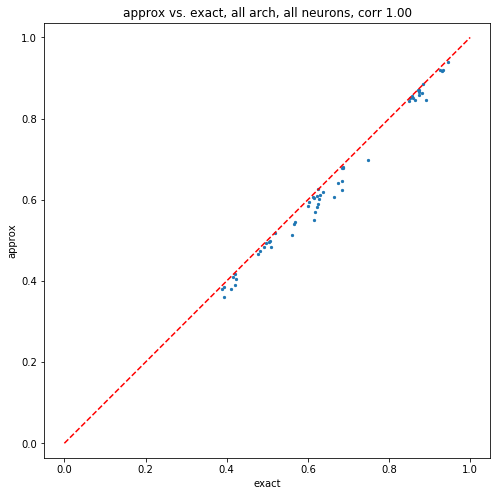

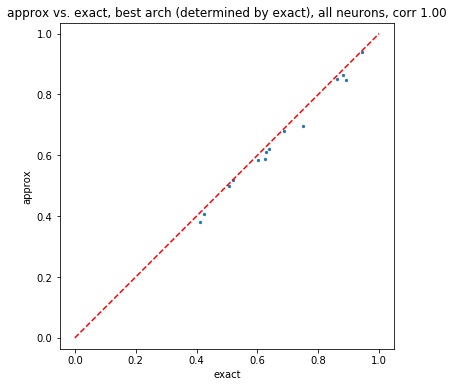

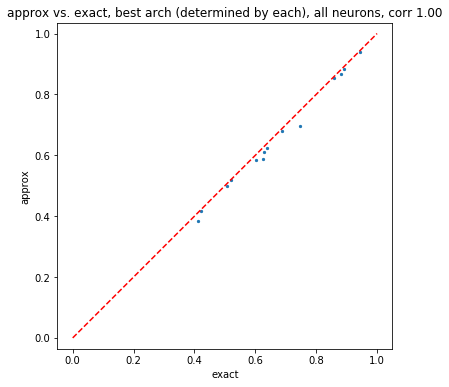

arch
c7_k5d2_k3d1p1_k6s2max    0.639567
c7_k4d2_k3d1p1_k6s2max    0.638838
c7_k7d1_k3d1p1_k6s2max    0.637673
c7_k5d1_k3d1p1_k6s2max    0.629971
dtype: float64
arch
c7_k4d2_k3d1p1_k6s2max    0.611377
c7_k5d2_k3d1p1_k6s2max    0.608241
c7_k7d1_k3d1p1_k6s2max    0.606497
c7_k5d1_k3d1p1_k6s2max    0.600980
dtype: float64
arch
c7_k5d2_k3d1p1_k6s2max    0.639567
c7_k4d2_k3d1p1_k6s2max    0.638838
c7_k7d1_k3d1p1_k6s2max    0.637673
c7_k5d1_k3d1p1_k6s2max    0.629971
dtype: float64
arch
c7_k4d2_k3d1p1_k6s2max    0.611377
c7_k5d2_k3d1p1_k6s2max    0.608241
c7_k7d1_k3d1p1_k6s2max    0.606497
c7_k5d1_k3d1p1_k6s2max    0.600980
dtype: float64


In [14]:
tmp_stuff = study_one_subset(all_data['corr'].xs('OT', level='subset'))